In [90]:
from utils.load_data import load_data
from utils.filters import highpass_filter, lowpass_filter
import numpy as np
from utils.plot_signal import plot_signal
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from utils.model import train_linear_model, create_lagged_features


In [91]:
# Load data
data_abdomen1, data_abdomen2, data_abdomen3, data_thorax1, data_thorax2 = load_data()

# Preprocessing & Signal Processing
1. normalization
2. high pass filter
3. low pass filter
4. 

#### Failed attempts
1. Naive first approach of subtraction - could not successfully isolate.
2. Band-pass filtering - gives signal which looks like sinusoid.
3. Removing combined signal maximums to try and obtain child. Noise was problematic and combined signal wasnt able to be disected.

In [92]:
# Normalize the data to unit variance and zero mean
thorax1 = (data_thorax1 - data_thorax1.mean()) / data_thorax1.std()
thorax2 = (data_thorax2 - data_thorax2.mean()) / data_thorax2.std()
abdomen1 = (data_abdomen1 - data_abdomen1.mean()) / data_abdomen1.std()
abdomen2 = (data_abdomen2 - data_abdomen2.mean()) / data_abdomen2.std()
abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()
# Create a copy of abdomen3 normalized to unit variance and zero mean
normalized_abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()

#### High Pass Filter
Why do we use it?

Parameter justification:
  - 
  -
  -

In [93]:
# High pass filter to remove baseline wander
cutoff_baseline_thorax = 0.5
cutoff_baseline_abdomen = 30
fs = 1000

thorax1 = highpass_filter(thorax1, cutoff_baseline_thorax, fs, order=2)
thorax2 = highpass_filter(thorax2, cutoff_baseline_thorax, fs, order=2)
abdomen1 = highpass_filter(abdomen1, cutoff_baseline_abdomen, fs, order=2)
abdomen2 = highpass_filter(abdomen2, cutoff_baseline_abdomen, fs, order=2)
abdomen3 = highpass_filter(abdomen3, cutoff_baseline_abdomen, fs, order=2)

## Linear Model


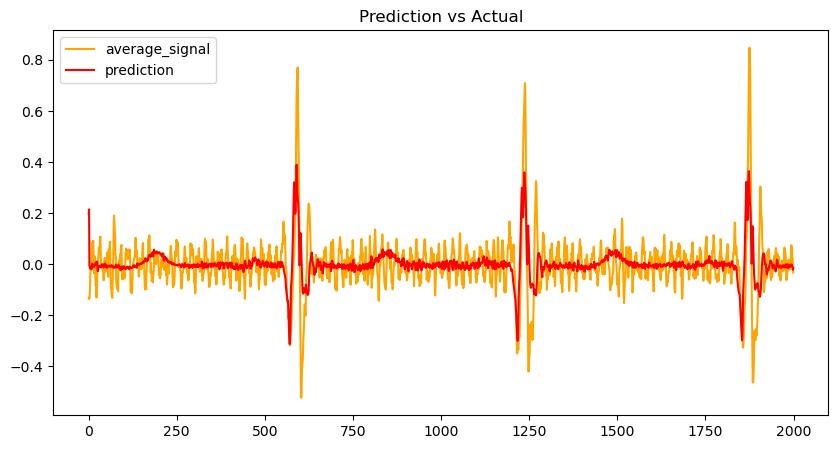

Mean Squared Error on Test Set: 0.0154


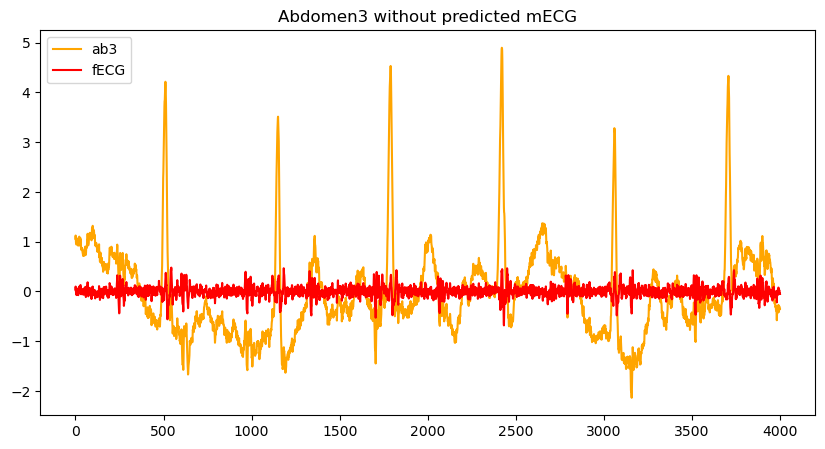

In [98]:
thorax1 = thorax1.reshape(-1, 1)
thorax2 = thorax2.reshape(-1, 1)
abdomen1 = abdomen1.reshape(-1, 1)
abdomen2 = abdomen2.reshape(-1, 1)
abdomen3 = abdomen3.reshape(-1, 1)


# Train linear model
thorax1_lagged = create_lagged_features(thorax1)
thorax2_lagged = create_lagged_features(thorax2)

linear_model = train_linear_model(np.hstack((thorax1_lagged, thorax2_lagged)), (abdomen1 + abdomen2) / 2)


# Predict using linear model
linear_prediction = linear_model.predict(np.hstack((thorax2_lagged, thorax2_lagged))) # <- is thorax2 twice correct?

plt.figure(figsize=(10,5))
plt.plot((abdomen1[:2000] + abdomen2[:2000]) / 2, label='average_signal', color='orange')
plt.plot(linear_prediction[:2000], label='prediction', color='red')
plt.title("Prediction vs Actual")
plt.legend()
plt.show()

# Measure performance
mse = mean_squared_error(abdomen2, linear_prediction)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

abdomen3_flattened_normalized = normalized_abdomen3.values.flatten()

# Show abdomen3 - predicted abdominal mECG
plt.figure(figsize=(10,5))
plt.plot(abdomen3_flattened_normalized[2000:6000], label='ab3', color='orange')
plt.plot((abdomen3[:6000] - linear_prediction[:6000])[2000:6000], label='fECG', color='red')
plt.title("Abdomen3 without predicted mECG")
plt.legend()
plt.show()

### Iteration on Model
We realized we need larger windows to train our model onl. If our time series features are sparsel, we should ensure the windows are large enough to incorporate it.

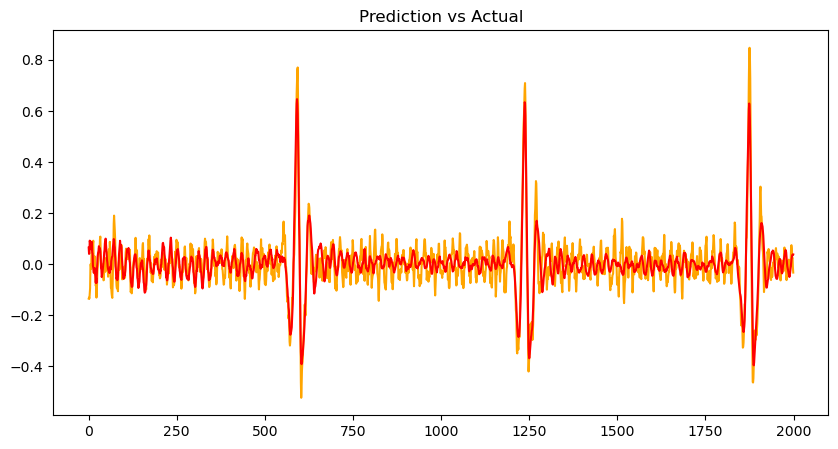

Mean Squared Error on Test Set: 0.0095


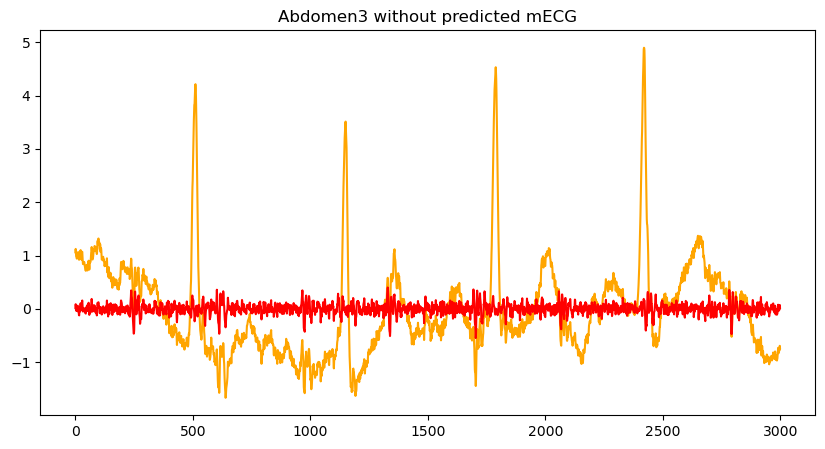

In [95]:
thorax1_lagged = create_lagged_features(thorax1, 600)
thorax2_lagged = create_lagged_features(thorax2, 600)

linear_model = train_linear_model(np.hstack((thorax1_lagged, thorax2_lagged)), (abdomen1 + abdomen2) / 2)


# Predict using linear model
linear_prediction = linear_model.predict(np.hstack((thorax2_lagged, thorax2_lagged)))

plt.figure(figsize=(10,5))
plt.plot((abdomen1[:2000] + abdomen2[:2000]) / 2, label='comb', color='orange')
plt.plot(linear_prediction[:2000], label='prediction', color='red')
plt.title("Prediction vs Actual")
plt.show()

# Measure performance
mse = mean_squared_error(abdomen2, linear_prediction)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

abdomen3_flattened_normalized = normalized_abdomen3.values.flatten()

# Show abdomen3 - predicted abdominal mECG
plt.figure(figsize=(10,5))
plt.plot(abdomen3_flattened_normalized[2000:5000], label='ab3', color='orange')
plt.plot((abdomen3[:6000] - linear_prediction[:6000])[2000:5000], label='fECG', color='red')
plt.title("Abdomen3 without predicted mECG")
plt.show()



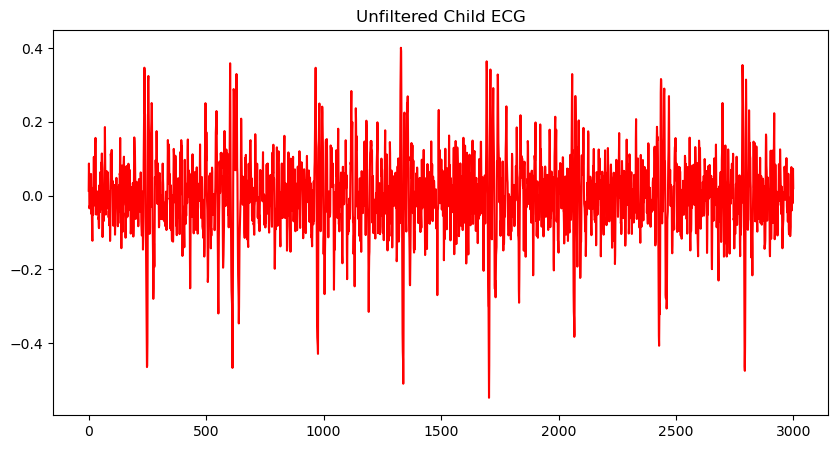

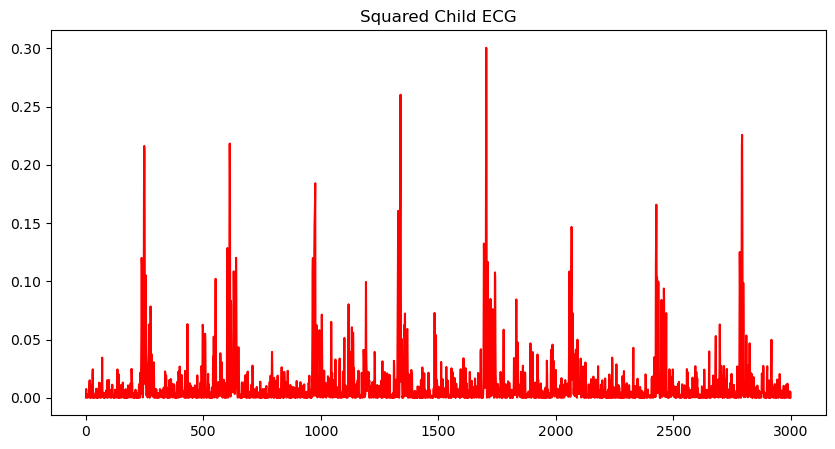

In [96]:
result = (abdomen3[:6000] - linear_prediction[:6000])[2000:5000]

plt.figure(figsize=(10,5))
plt.plot(result, label='fECG', color='red')
plt.title("Unfiltered Child ECG")
plt.show()

result = result ** 2

#Plot the squared result
plt.figure(figsize=(10,5))
plt.plot(result, label='fECG', color='red')
plt.title("Squared Child ECG")
plt.show()

(3000, 1)


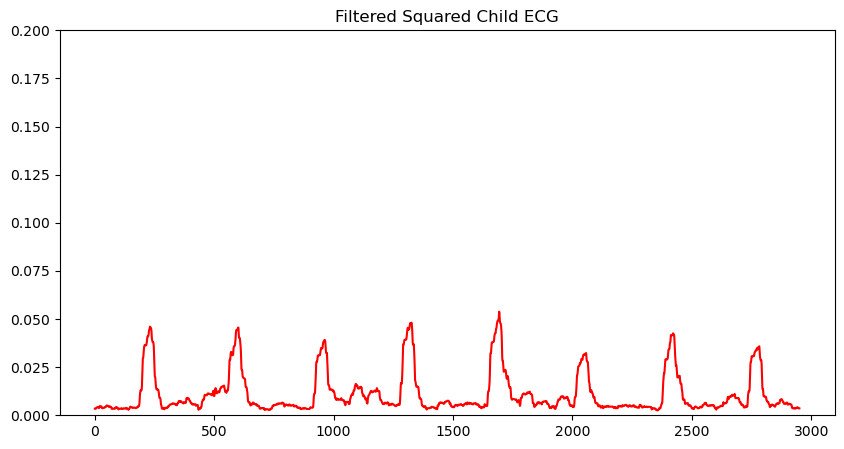

In [97]:
print(result.shape)
#Apply moving average filter to the squared result
result_convolved = np.convolve(result.flatten(), np.ones(50)/50, mode='valid')

#Plot the filtered squared result
plt.figure(figsize=(10,5))
plt.plot(result_convolved, label='fECG', color='red')
plt.ylim(0, 0.2)
plt.title("Filtered Squared Child ECG")
plt.show()
